# Introduction

In this notebook, we read the collected benchmarking results (timing and memory usage) and combine them with dataset size. Further, we use the data to assess the scalability of data integration methods.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Create table with scenario meta data

We have the different scenarios with varying complexity. Here, we add the number of cells per scenario.

For the ATAC data, we test the influence of the number of features in a linear model as they vary considerably from the number of genes in the RNA scenarios.

Mouse brain ATAC small has the following number of features: 110,724 windows, 94,088 peaks, and 3,429 genes, while mouse brain ATAC large has 118,723 windows, 96,924 peaks, and 3,580 genes. In the hvg setting, we selected 2,000 highly variable features, which impacts the runtime and memory usage compared to the full_feature setting. 

In [5]:
scenario = ['pancreas', 'mouse_brain', 
            'mouse_brain_atac_genes_large',
       'mouse_brain_atac_genes_small', 'mouse_brain_atac_peaks_large',
       'mouse_brain_atac_peaks_small', 'mouse_brain_atac_windows_large',
       'mouse_brain_atac_windows_small',
            'immune_cell_hum', 'immune_cell_hum_mou', 'lung_atlas',
            'simulations_1_1', 'simulations_2'
           ]
scenario_size = [16382, 978734, 
                 84813, 11270, #genes
                 84813, 11597, #peaks
                 84813, 11270, #windows
                 33506, 97952, 32472, 12097, 19318]
scenario_batches = [6,4,10,3,10,3,10,3,10, 23, 16, 6, 16]
scenario_type = ['RNA', 'RNA', 'ATAC','ATAC','ATAC','ATAC','ATAC','ATAC', 'RNA','RNA', 'RNA','RNA', 'RNA']
scenario_features = [18771, 14858, 
            3580, 3429, #genes
                     96924, 94088, #peaks
                     118723,110724, #windows
       
            12303,
                     8135, 
                     15148,
            9979, 10000]


In [7]:
meta = pd.DataFrame({'scenario1' : scenario, 'size' : scenario_size, 
                     'n_batches' : scenario_batches, 
                     'n_features' : scenario_features,
                     'scenario_type' : scenario_type})

In [8]:
meta['scenario1'][np.argsort(meta['size'])].values

array(['mouse_brain_atac_genes_small', 'mouse_brain_atac_windows_small',
       'mouse_brain_atac_peaks_small', 'simulations_1_1', 'pancreas',
       'simulations_2', 'lung_atlas', 'immune_cell_hum',
       'mouse_brain_atac_genes_large', 'mouse_brain_atac_peaks_large',
       'mouse_brain_atac_windows_large', 'immune_cell_hum_mou',
       'mouse_brain'], dtype=object)

# Load benchmark data

Read all files where a benchmark is available. Daniel Strobl has concatenated all benchmarking results already in a `.csv` file.

In [9]:
data = pd.read_csv('./../data/benchmarks.csv')

In [10]:
data

,scenario,s,h_m_s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load
0,immune_cell_hum_mou/integration/scaled/full_fe...,308.5328,0:05:08,25222.29,36233.86,25213.81,25216.42,0.00,1361.94,88.04
1,immune_cell_hum_mou/integration/scaled/full_fe...,81901.4316,22:45:01,760801.93,802118.83,89319.22,89321.85,975.93,2793.21,310.55
2,immune_cell_hum_mou/integration/scaled/full_fe...,252.5243,0:04:12,12857.75,36233.86,12851.20,12853.79,971.67,814.54,83.70
3,immune_cell_hum_mou/integration/scaled/full_fe...,311.0663,0:05:11,13115.96,36233.86,13107.56,13110.16,1198.37,2900.28,85.53
4,immune_cell_hum_mou/integration/scaled/full_fe...,8299.0838,2:18:19,13830.43,36233.86,13825.75,13828.36,997.98,851.73,327.86
...,...,...,...,...,...,...,...,...,...,...
424,mouse_brain_atac_genes_large/integration/unsca...,943.3692,0:15:43,254787.78,260402.08,32247.88,32248.56,166.15,710.71,321.27
425,mouse_brain_atac_genes_large/integration/unsca...,1473.3660,0:24:33,41802.69,42599.82,41866.16,41866.89,883.28,368.76,94.62
426,mouse_brain_atac_genes_large/integration/unsca...,693.2487,0:11:33,11619.68,35017.61,11614.98,11615.72,190.18,3819.49,95.24
427,mouse_brain_atac_genes_large/integration/unsca...,2338.1654,0:38:58,14910.31,36234.48,14905.85,14906.52,874.50,133.00,95.20


Split the scenario names at the `/` and add the info as columns.

In [11]:
data['scenario'][1]

'immune_cell_hum_mou/integration/scaled/full_feature/mnn.h5ad'

In [12]:
column_names = ['scenario1', 'call', 'scale', 'features','method', 'scenario']
df = pd.DataFrame(columns = column_names)
for file in data['scenario']:
    infos = file.split('/')
    tmp = pd.DataFrame({'scenario1': infos[0],
                        'call': infos[1],
                        'scale': infos[2],
                        'features': infos[3],
                        'method': '-'.join(infos[4:]),
                        'scenario': file
                    }, index = ['0'])
    df = pd.concat([df, tmp], ignore_index=True)

In [13]:
df.shape

(429, 6)

In [14]:
np.unique(df['scenario1'])

array(['immune_cell_hum', 'immune_cell_hum_mou', 'lung_atlas',
       'mouse_brain', 'mouse_brain_atac_genes_large',
       'mouse_brain_atac_genes_small', 'mouse_brain_atac_peaks_large',
       'mouse_brain_atac_peaks_small', 'mouse_brain_atac_windows_large',
       'mouse_brain_atac_windows_small', 'pancreas', 'simulations_1_1',
       'simulations_2'], dtype=object)

# Process benchmark data

In our simulations, we had some methods in R and some in python. Therefore, we exclude `seurat.h5ad`, `harmony.h5ad` and `conos.h5ad`, because those files show only the timing for file conversion.

Further, we exclude the `prep_h5ad` and `prep_RDS` steps.

In [15]:
df['method'].value_counts()

saucie.h5ad         34
desc.h5ad           34
bbknn.h5ad          34
R-harmony.RDS       33
R-conos.RDS         32
combat.h5ad         32
scanorama.h5ad      31
R-fastmnn.RDS       30
mnn.h5ad            27
scgen.h5ad          27
R-seuratrpca.RDS    24
R-seurat.RDS        23
R-liger.RDS         19
scanvi.h5ad         18
scvi.h5ad           18
trvae.h5ad          13
Name: method, dtype: int64

In [16]:
idx = np.invert(np.in1d(df['method'], ['seurat.h5ad', 'harmony.h5ad', 'conos.h5ad', 'prep_h5ad', 'prep_RDS']))

In [17]:
integ_runs = df.iloc[idx, :]

In [18]:
idx2 = np.invert(np.in1d(integ_runs['scenario'], ['simulations_1']))

In [19]:
integ_runs = integ_runs.iloc[idx2, :]

In [20]:
integ_runs['scenario1'].value_counts()

immune_cell_hum                   56
simulations_1_1                   56
pancreas                          56
lung_atlas                        55
simulations_2                     52
immune_cell_hum_mou               49
mouse_brain                       29
mouse_brain_atac_genes_small      16
mouse_brain_atac_peaks_small      16
mouse_brain_atac_windows_small    16
mouse_brain_atac_genes_large      14
mouse_brain_atac_peaks_large       7
mouse_brain_atac_windows_large     7
Name: scenario1, dtype: int64

In [21]:
methods = [meth.split('.')[0] for meth in integ_runs['method']]
methods2 = [meth.split('-')[-1] for meth in methods]

In [22]:
integ_runs['method'] = methods2

In [23]:
integ_runs['method'].value_counts()

saucie        34
bbknn         34
desc          34
harmony       33
combat        32
conos         32
scanorama     31
fastmnn       30
scgen         27
mnn           27
seuratrpca    24
seurat        23
liger         19
scvi          18
scanvi        18
trvae         13
Name: method, dtype: int64

Sanity check whether we collected the correct files.

In [24]:
pd.crosstab(integ_runs['scenario1'],integ_runs['method'], margins=True)

method,bbknn,combat,conos,desc,fastmnn,harmony,liger,mnn,saucie,scanorama,scanvi,scgen,scvi,seurat,seuratrpca,trvae,All
scenario1,,,,,,,,,,,,,,,,,
immune_cell_hum,4,4,4,4,4,4,2,4,4,4,2,4,2,4,4,2,56
immune_cell_hum_mou,4,4,4,4,4,4,2,4,4,4,2,3,2,0,4,0,49
lung_atlas,4,4,4,4,4,4,2,4,4,4,2,4,2,3,4,2,55
mouse_brain,4,2,2,4,2,3,1,0,4,3,2,0,2,0,0,0,29
mouse_brain_atac_genes_large,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,14
mouse_brain_atac_genes_small,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,16
mouse_brain_atac_peaks_large,1,1,1,1,0,1,1,0,1,0,0,0,0,0,0,0,7
mouse_brain_atac_peaks_small,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,16
mouse_brain_atac_windows_large,1,1,1,1,0,1,1,0,1,0,0,0,0,0,0,0,7


## Merge metadata and benchmark results

Merge data set sizes and batch number to table with integration runs.

In [25]:
runs_meta = integ_runs.merge(meta, on='scenario1')

In [26]:
runs_meta.head()

,scenario1,call,scale,features,method,scenario,size,n_batches,n_features,scenario_type
0,immune_cell_hum_mou,integration,scaled,full_feature,combat,immune_cell_hum_mou/integration/scaled/full_fe...,97952,23,8135,RNA
1,immune_cell_hum_mou,integration,scaled,full_feature,mnn,immune_cell_hum_mou/integration/scaled/full_fe...,97952,23,8135,RNA
2,immune_cell_hum_mou,integration,scaled,full_feature,bbknn,immune_cell_hum_mou/integration/scaled/full_fe...,97952,23,8135,RNA
3,immune_cell_hum_mou,integration,scaled,full_feature,saucie,immune_cell_hum_mou/integration/scaled/full_fe...,97952,23,8135,RNA
4,immune_cell_hum_mou,integration,scaled,full_feature,desc,immune_cell_hum_mou/integration/scaled/full_fe...,97952,23,8135,RNA


Replace the number of features for 'hvg' by 2000.

In [30]:
runs_meta.loc[runs_meta['features']=='hvg', 'n_features'] = 2000

In [34]:
runs_meta['n_features'].value_counts()

2000      181
18771      28
9979       28
12303      28
15148      27
10000      26
8135       24
94088      16
3429       16
110724     16
3580       14
14858      11
118723      7
96924       7
Name: n_features, dtype: int64

In [78]:
runs_meta['method'].value_counts()

bbknn         34
desc          34
saucie        34
harmony       33
combat        32
conos         32
scanorama     31
fastmnn       30
mnn           27
scgen         27
seuratrpca    24
seurat        23
liger         19
scanvi        18
scvi          18
trvae         13
Name: method, dtype: int64

Merge with the benchmark data.

In [35]:
runs_meta = runs_meta.merge(data, on='scenario')

Save to file.

In [36]:
runs_meta.to_csv('./../data/201211_combined_benchmark_performance_measures.csv')

Look up individual methods.

In [37]:
runs_meta.loc[runs_meta['method']=='fastmnn'][['scenario1', 'features', 'scale', 'max_pss']]

,scenario1,features,scale,max_pss
9,immune_cell_hum_mou,full_feature,scaled,31680.16
18,immune_cell_hum_mou,hvg,scaled,8558.00
30,immune_cell_hum_mou,full_feature,unscaled,20821.68
48,immune_cell_hum_mou,hvg,unscaled,6573.75
70,mouse_brain_atac_windows_small,full_feature,unscaled,26909.51
82,simulations_2,hvg,scaled,4018.00
90,simulations_2,full_feature,scaled,10170.58
108,simulations_2,hvg,unscaled,3934.08
119,simulations_2,full_feature,unscaled,9428.78
134,mouse_brain_atac_peaks_small,full_feature,unscaled,23836.68


In [38]:
runs_meta.loc[runs_meta['method']=='seuratrpca'][['scenario1', 'features', 'scale', 'max_pss']]

,scenario1,features,scale,max_pss
8,immune_cell_hum_mou,full_feature,scaled,154243.81
17,immune_cell_hum_mou,hvg,scaled,67387.64
31,immune_cell_hum_mou,full_feature,unscaled,131320.61
45,immune_cell_hum_mou,hvg,unscaled,44087.51
68,mouse_brain_atac_windows_small,full_feature,unscaled,123266.55
136,mouse_brain_atac_peaks_small,full_feature,unscaled,104403.48
155,pancreas,full_feature,scaled,61038.81
169,pancreas,hvg,scaled,24951.38
184,pancreas,full_feature,unscaled,57524.33
200,pancreas,hvg,unscaled,19054.31


In [39]:
runs_meta.loc[runs_meta['method']=='seurat'][['scenario1', 'features', 'scale', 'max_pss']]

,scenario1,features,scale,max_pss
69,mouse_brain_atac_windows_small,full_feature,unscaled,111810.90
80,simulations_2,hvg,scaled,19052.88
93,simulations_2,full_feature,scaled,46687.38
107,simulations_2,hvg,unscaled,20488.35
123,simulations_2,full_feature,unscaled,35896.05
138,mouse_brain_atac_peaks_small,full_feature,unscaled,83689.41
157,pancreas,full_feature,scaled,50902.77
168,pancreas,hvg,scaled,23815.03
183,pancreas,full_feature,unscaled,31702.98
202,pancreas,hvg,unscaled,9868.55


In [40]:
runs_meta.loc[runs_meta['method']=='harmony'][['scenario1', 'features', 'scale', 'max_pss']]

,scenario1,features,scale,max_pss
7,immune_cell_hum_mou,full_feature,scaled,32587.99
19,immune_cell_hum_mou,hvg,scaled,10112.86
34,immune_cell_hum_mou,full_feature,unscaled,24015.09
47,immune_cell_hum_mou,hvg,unscaled,6905.61
55,mouse_brain_atac_peaks_large,full_feature,unscaled,279423.71
66,mouse_brain_atac_windows_small,full_feature,unscaled,32281.27
81,simulations_2,hvg,scaled,3566.74
91,simulations_2,full_feature,scaled,9126.59
106,simulations_2,hvg,unscaled,3334.71
122,simulations_2,full_feature,unscaled,9230.73


# Visualisation

Here, we visualise the CPU time ("s") and the memory usage ("max_uss" and "max_pss") for all runs.

In [2]:
runs_meta = pd.read_csv('./../data/201211_combined_benchmark_performance_measures.csv')

Due to the fair amount of data, we tried two different color schemes: `tab20c` and the `Polychrome36` from R version `4.0` (hex color codes were copied manually).

In [41]:
#use colors from the Polychrome36 palette
colors = ['#5A5156', '#E4E1E3', '#F6222E', '#FE00FA', '#16FF32', 
          '#3283FE', '#FEAF16', '#B00068', '#1CFFCE', '#90AD1C', '#2ED9FF',
          '#DEA0FD', '#AA0DFE', '#F8A19F', '#325A9B', '#C4451C' 
         ]
sb.set_palette(sb.color_palette(colors))

## Boxplots

Visualise runtime and memory use per method and data scenario in a boxplot.

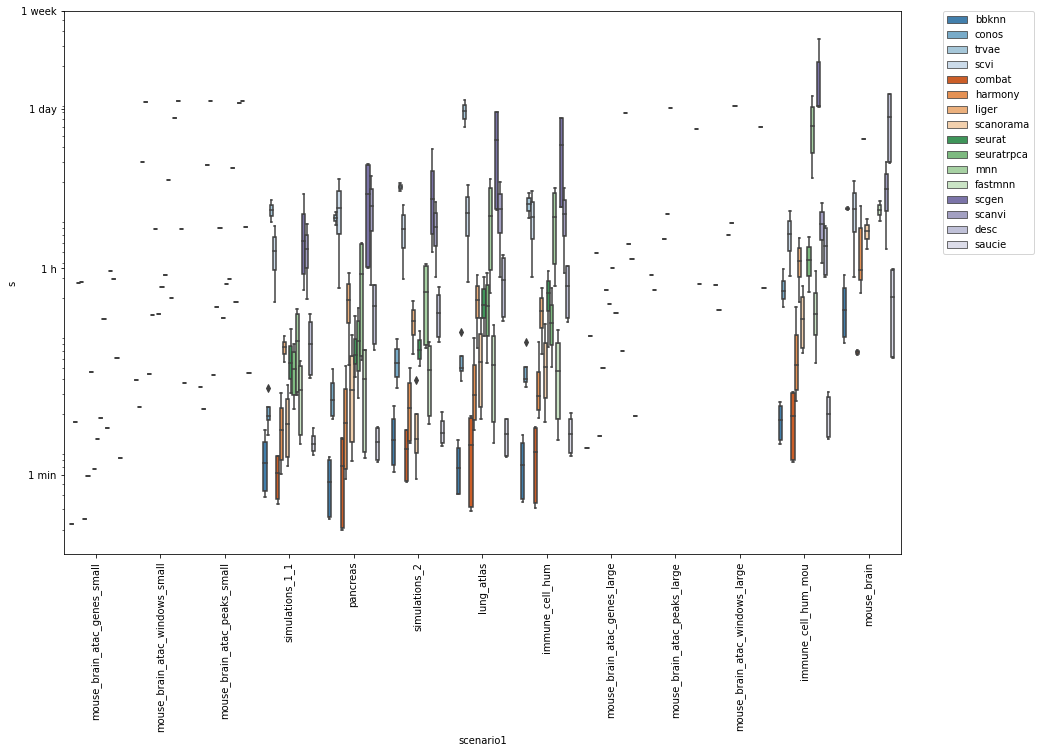

In [42]:
rcParams['figure.figsize']=(15,10)
ax = sb.boxplot(x="scenario1", y="s", hue='method', 
                hue_order=['bbknn', 'conos', 
                           'trvae', 'scvi', 'combat',
                           'harmony', 'liger', 'scanorama',
                           'seurat','seuratrpca', 'mnn', 'fastmnn',
                           'scgen', 'scanvi', 'desc', 'saucie'],
                order = meta['scenario1'][np.argsort(meta['size'])].values,
                data=runs_meta, palette='tab20c')
ax.set(yscale="log")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.yticks([60, 3600, 86400,604800], ['1 min', '1 h', '1 day', '1 week'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

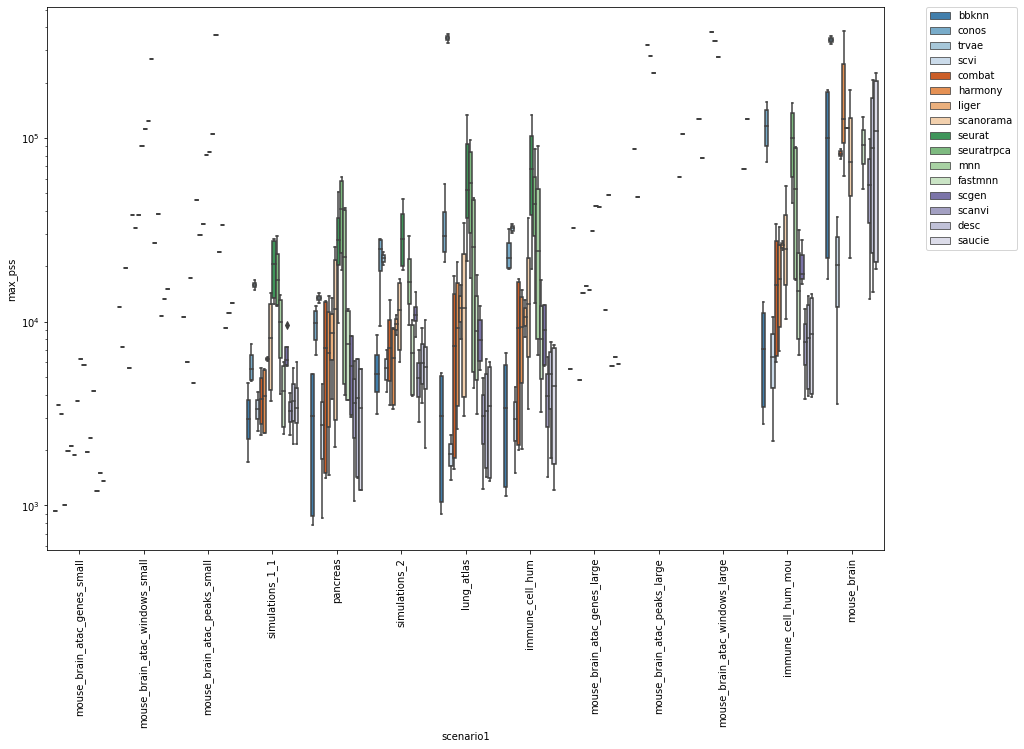

In [43]:
rcParams['figure.figsize']=(15,10)
ax = sb.boxplot(x="scenario1", y="max_pss", hue='method', 
                hue_order=['bbknn', 'conos', 
                           'trvae', 'scvi', 'combat',
                           'harmony', 'liger', 'scanorama',
                           'seurat','seuratrpca', 'mnn', 'fastmnn',
                           'scgen', 'scanvi', 'desc', 'saucie'],
                order = meta['scenario1'][np.argsort(meta['size'])].values,
                data=runs_meta, palette='tab20c')
ax.set(yscale="log")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

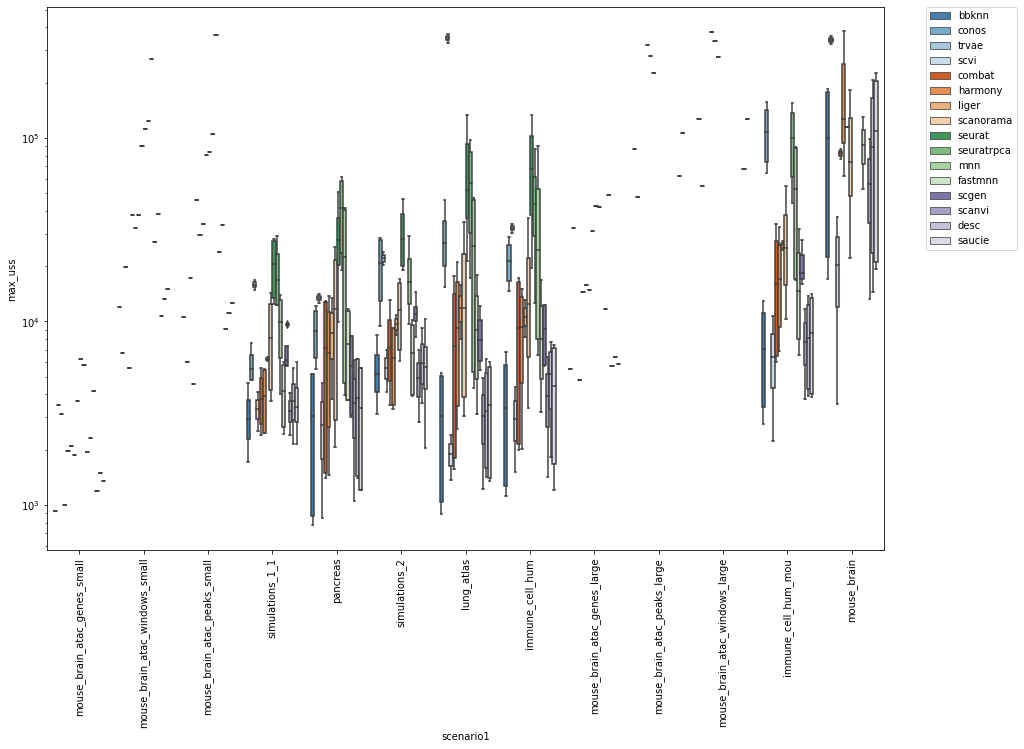

In [44]:
rcParams['figure.figsize']=(15,10)
ax = sb.boxplot(x="scenario1", y="max_uss", hue='method', 
                hue_order=['bbknn', 'conos', 
                           'trvae', 'scvi', 'combat',
                           'harmony', 'liger', 'scanorama',
                           'seurat','seuratrpca', 'mnn', 'fastmnn',
                           'scgen', 'scanvi', 'desc', 'saucie'],
                order = meta['scenario1'][np.argsort(meta['size'])].values,
                data=runs_meta, palette='tab20c')
ax.set(yscale="log")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Boxplots per batch

Visualise runtime and memory use per method and data scenario in a boxplot.

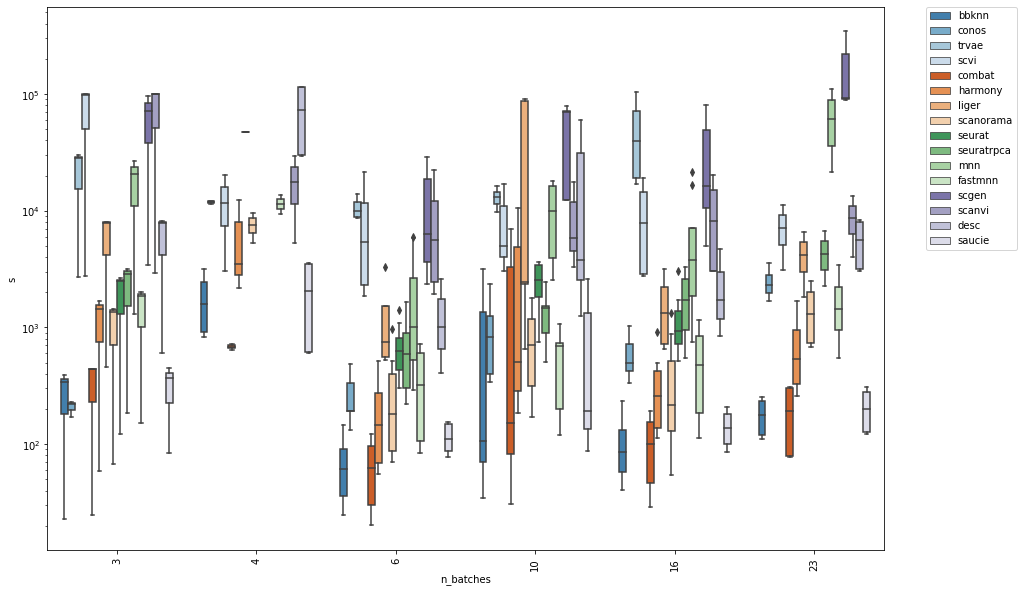

In [45]:
rcParams['figure.figsize']=(15,10)
ax = sb.boxplot(x="n_batches", y="s", hue='method', 
                hue_order=['bbknn', 'conos', 
                           'trvae', 'scvi', 'combat',
                           'harmony', 'liger', 'scanorama',
                           'seurat','seuratrpca', 'mnn', 'fastmnn',
                           'scgen', 'scanvi', 'desc', 'saucie'],
                #order = meta['scenario'][np.argsort(meta['size'])].values,
                data=runs_meta, palette='tab20c')
ax.set(yscale="log")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

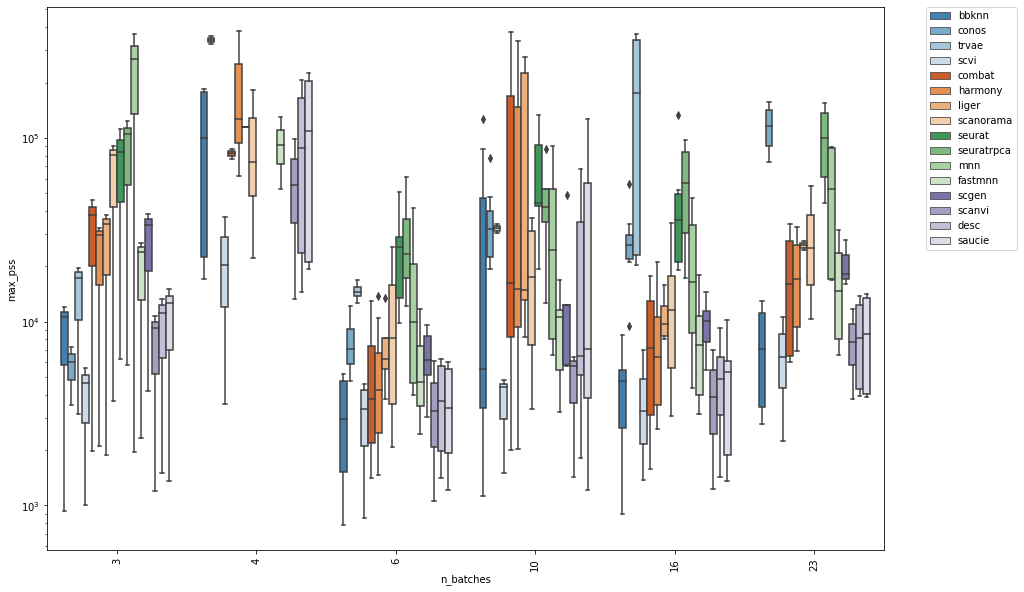

In [46]:
rcParams['figure.figsize']=(15,10)
ax = sb.boxplot(x="n_batches", y="max_pss", hue='method', 
                hue_order=['bbknn', 'conos', 
                           'trvae', 'scvi', 'combat',
                           'harmony', 'liger', 'scanorama',
                           'seurat','seuratrpca', 'mnn', 'fastmnn',
                           'scgen', 'scanvi', 'desc', 'saucie'],
                #order = meta['scenario'][np.argsort(meta['size'])].values,
                data=runs_meta, palette='tab20c')
ax.set(yscale="log")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

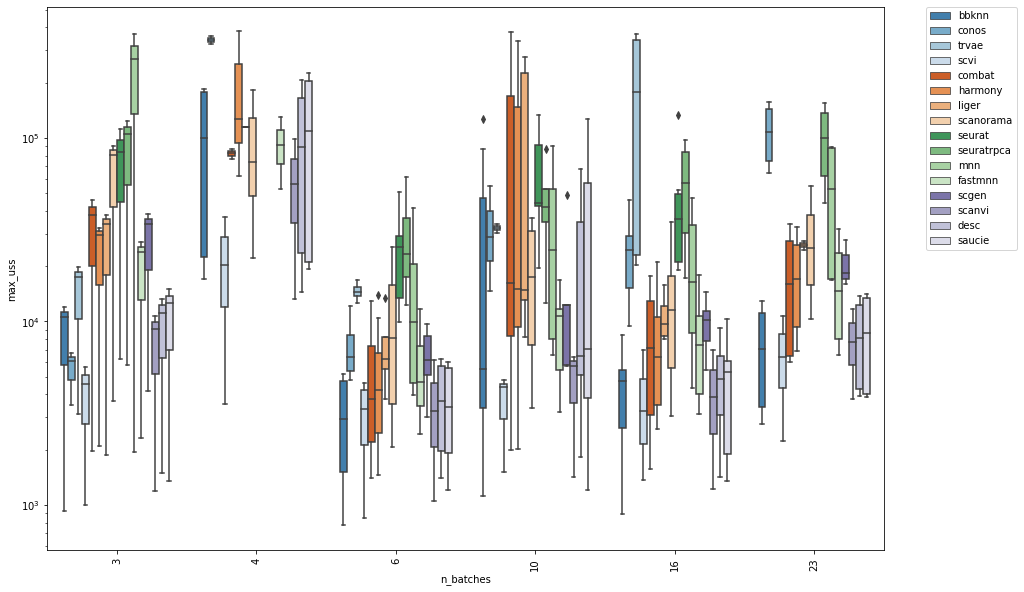

In [47]:
rcParams['figure.figsize']=(15,10)
ax = sb.boxplot(x="n_batches", y="max_uss", hue='method', 
                hue_order=['bbknn', 'conos', 
                           'trvae', 'scvi', 'combat',
                           'harmony', 'liger', 'scanorama',
                           'seurat','seuratrpca', 'mnn', 'fastmnn',
                           'scgen', 'scanvi', 'desc', 'saucie'],
                #order = meta['scenario'][np.argsort(meta['size'])].values,
                data=runs_meta, palette='tab20c')
ax.set(yscale="log")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Boxplots per number of features

Visualise runtime and memory use per method and data scenario in a boxplot.

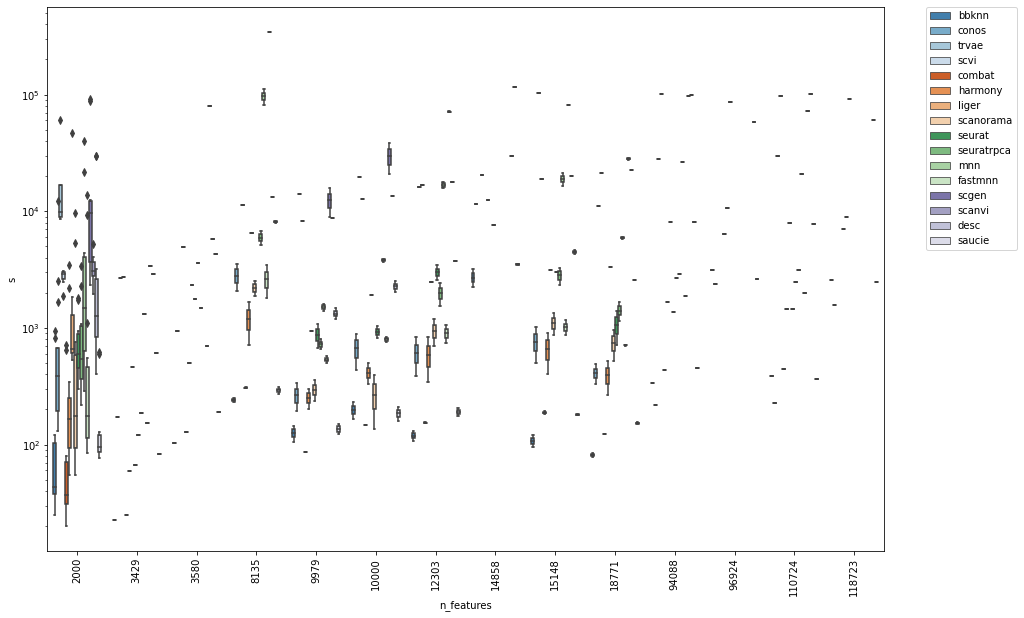

In [48]:
rcParams['figure.figsize']=(15,10)
ax = sb.boxplot(x="n_features", y="s", hue='method', 
                hue_order=['bbknn', 'conos', 
                           'trvae', 'scvi', 'combat',
                           'harmony', 'liger', 'scanorama',
                           'seurat','seuratrpca', 'mnn', 'fastmnn',
                           'scgen', 'scanvi', 'desc', 'saucie'],
                #order = meta['scenario'][np.argsort(meta['size'])].values,
                data=runs_meta, palette='tab20c')
ax.set(yscale="log")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

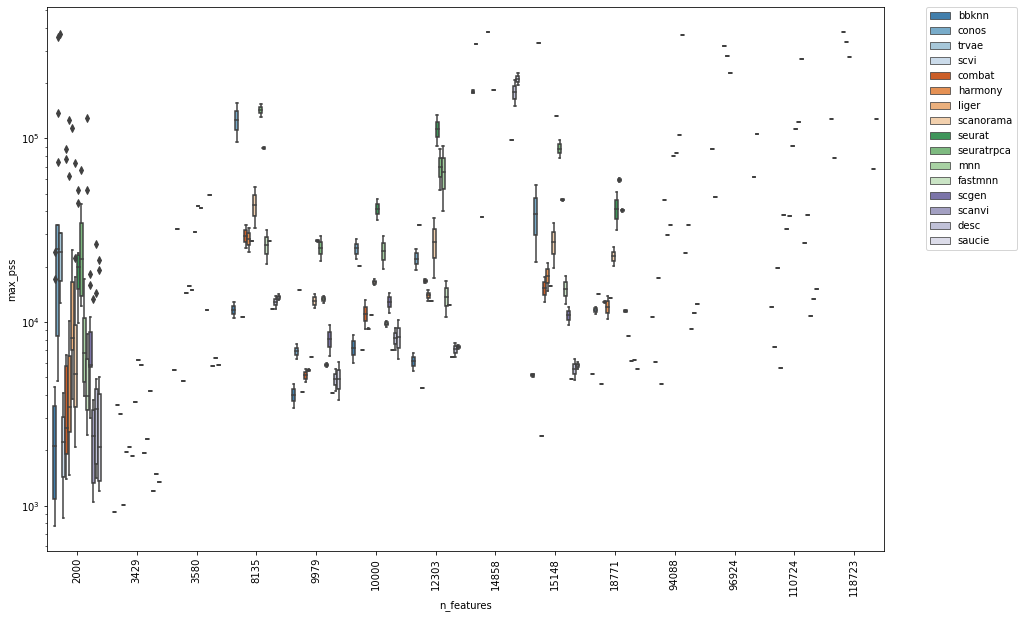

In [49]:
rcParams['figure.figsize']=(15,10)
ax = sb.boxplot(x="n_features", y="max_pss", hue='method', 
                hue_order=['bbknn', 'conos', 
                           'trvae', 'scvi', 'combat',
                           'harmony', 'liger', 'scanorama',
                           'seurat','seuratrpca', 'mnn', 'fastmnn',
                           'scgen', 'scanvi', 'desc', 'saucie'],
                #order = meta['scenario'][np.argsort(meta['size'])].values,
                data=runs_meta, palette='tab20c')
ax.set(yscale="log")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

## Scatterplots per method

Instead of boxplots, we create scatterplots per method to evaluate whether the runtime and memory usage scale log-linearly with the dataset size.

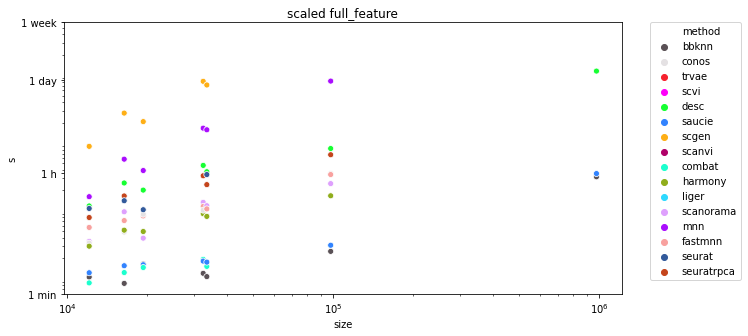

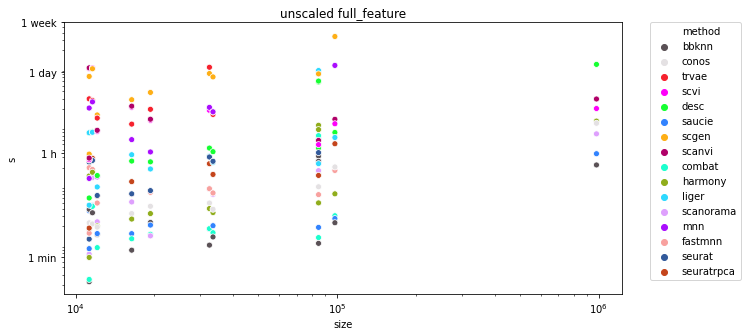

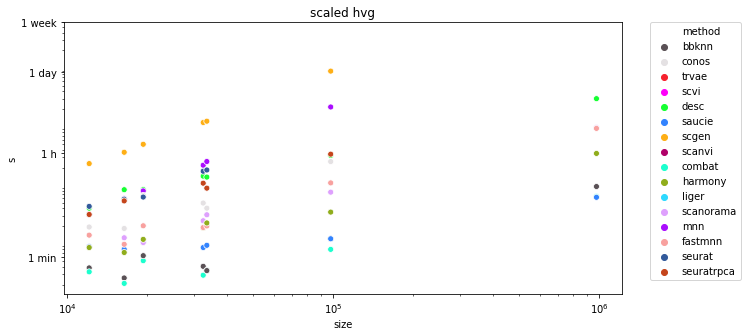

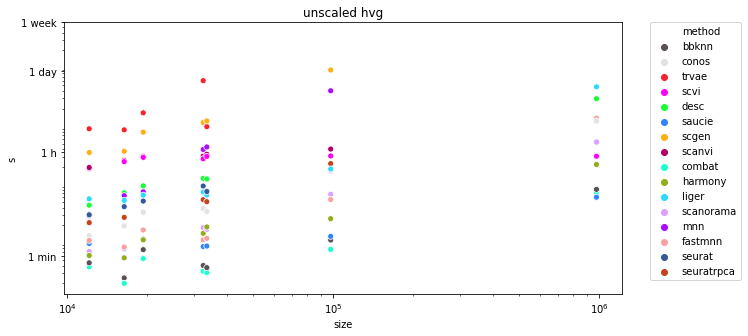

In [93]:


rcParams['figure.figsize'] = (10,5) 
for feat in ['full_feature', 'hvg']:
    for scala in ['scaled', 'unscaled']:
        tmp = runs_meta.loc[np.logical_and(runs_meta['features'] == feat,
                                           runs_meta['scale'] == scala
                                          ), :]
        ax = sb.scatterplot(x="size", y="s", hue='method',
                            hue_order=['bbknn', 'conos', 
                           'trvae', 'scvi', 'desc', 'saucie','scgen', 'scanvi', 
                                       'combat',
                           'harmony', 'liger', 'scanorama','mnn', 'fastmnn',
                           'seurat','seuratrpca', 
                           ],
                        #col='features', row='scale',
                        #order = meta['scenario'][np.argsort(meta['size'])].values,
                        data=tmp)
        ax.set(yscale="log")
        
        plt.yticks([60, 3600, 86400,604800], ['1 min', '1 h', '1 day', '1 week'])
        ax.set(xscale="log")
        ax.set_title(scala + ' ' + feat)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()

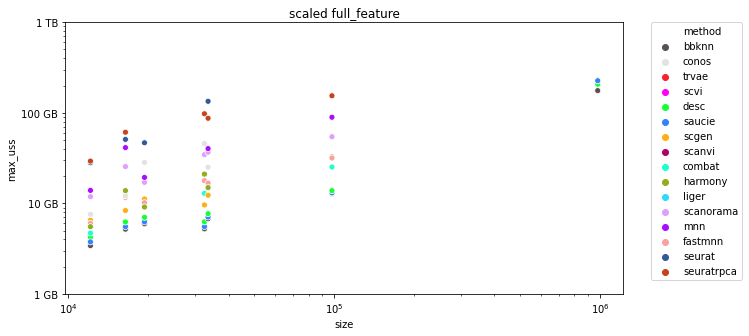

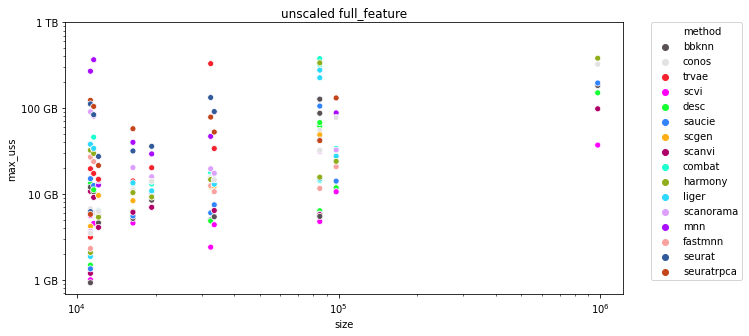

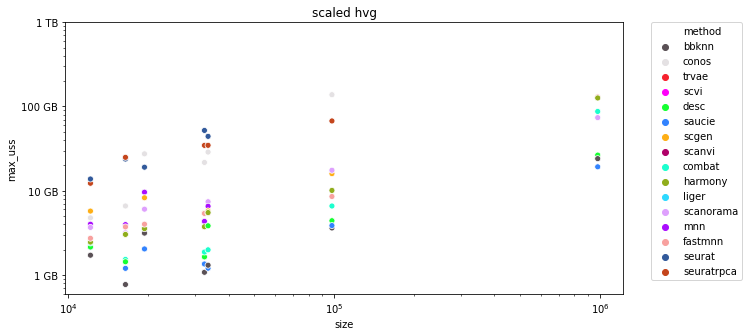

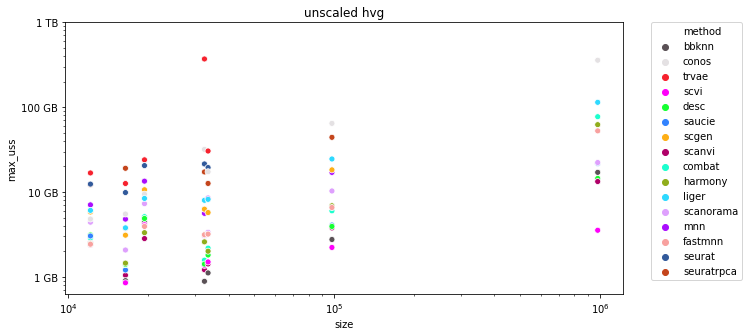

In [94]:
rcParams['figure.figsize'] = (10,5) 
for feat in ['full_feature', 'hvg']:
    for scala in ['scaled', 'unscaled']:
        tmp = runs_meta.loc[np.logical_and(runs_meta['features'] == feat,
                                           runs_meta['scale'] == scala
                                          ), :]
        ax = sb.scatterplot(x="size", y="max_uss", hue='method', 
                            hue_order=['bbknn', 'conos', 
                           'trvae', 'scvi', 'desc', 'saucie','scgen', 'scanvi', 
                                       'combat',
                           'harmony', 'liger', 'scanorama','mnn', 'fastmnn',
                           'seurat','seuratrpca'],
                        #col='features', row='scale',
                        #order = meta['scenario'][np.argsort(meta['size'])].values,
                        data=tmp)
        ax.set(yscale="log") 
        plt.yticks([1e3, 1e4, 1e5, 1e6], ['1 GB', '10 GB', '100 GB', '1 TB'])
        ax.set(xscale="log")
        ax.set_title(scala + ' ' + feat)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()

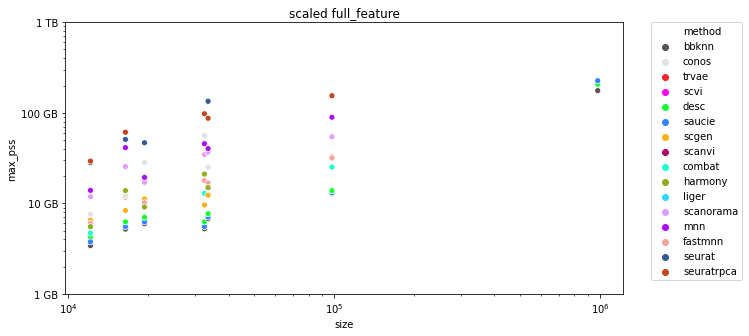

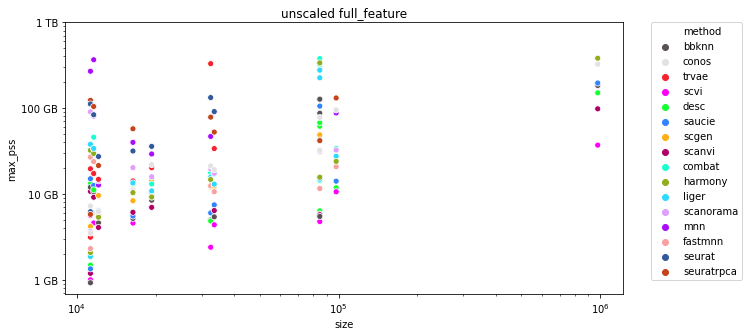

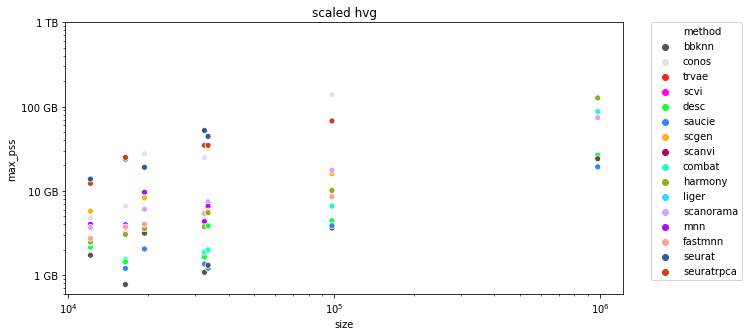

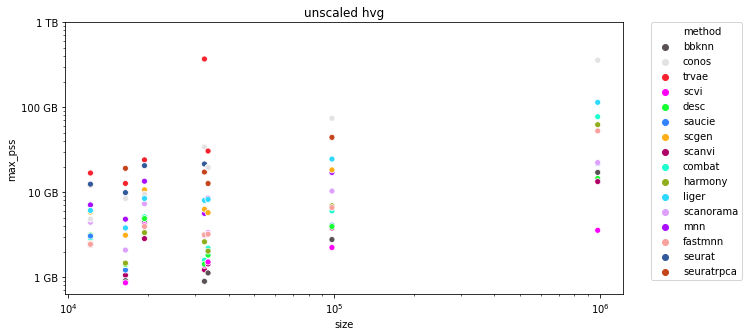

In [95]:
rcParams['figure.figsize'] = (10,5) 
for feat in ['full_feature', 'hvg']:
    for scala in ['scaled', 'unscaled']:
        tmp = runs_meta.loc[np.logical_and(runs_meta['features'] == feat,
                                           runs_meta['scale'] == scala
                                          ), :]
        ax = sb.scatterplot(x="size", y="max_pss", hue='method', 
                            hue_order=['bbknn', 'conos', 
                           'trvae', 'scvi', 'desc', 'saucie','scgen', 'scanvi', 
                                       'combat',
                           'harmony', 'liger', 'scanorama','mnn', 'fastmnn',
                           'seurat','seuratrpca'],
                        #col='features', row='scale',
                        #order = meta['scenario'][np.argsort(meta['size'])].values,
                        data=tmp)
        ax.set(yscale="log") 
        plt.yticks([1e3, 1e4, 1e5, 1e6], ['1 GB', '10 GB', '100 GB', '1 TB'])
        ax.set(xscale="log")
        ax.set_title(scala + ' ' + feat)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()

In order to decide which memory measurement to show in the manuscript, let us visualise `max_pss` and `max_uss` in a scatter plot.

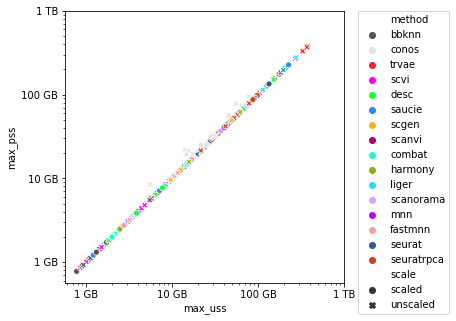

In [96]:
rcParams['figure.figsize']=(5,5)
ax = sb.scatterplot(x="max_uss", y="max_pss", hue='method', 
                            hue_order=['bbknn', 'conos', 
                           'trvae', 'scvi', 'desc', 'saucie','scgen', 'scanvi', 
                                       'combat',
                           'harmony', 'liger', 'scanorama','mnn', 'fastmnn',
                           'seurat','seuratrpca'],
                    style = 'scale',
                        #col='features', row='scale',
                        #order = meta['scenario'][np.argsort(meta['size'])].values,
                        data=runs_meta)
ax.set(yscale="log") 
plt.yticks([1e3, 1e4, 1e5, 1e6], ['1 GB', '10 GB', '100 GB', '1 TB'])
ax.set(xscale="log")
plt.xticks([1e3, 1e4, 1e5, 1e6], ['1 GB', '10 GB', '100 GB', '1 TB'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Compute the correlation of `max_pss` and `max_uss`.

In [97]:
runs_meta['max_pss'].corr(runs_meta['max_uss'])

0.999657158826004

Out of curiosity: How does `max_rss` behave compared to `max_uss`?

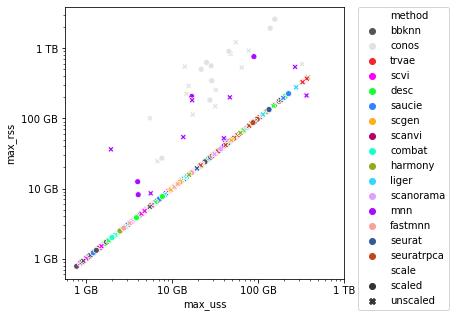

In [98]:
rcParams['figure.figsize']=(5,5)
ax = sb.scatterplot(x="max_uss", y="max_rss", hue='method', 
                            hue_order=['bbknn', 'conos', 
                           'trvae', 'scvi', 'desc', 'saucie','scgen', 'scanvi', 
                                       'combat',
                           'harmony', 'liger', 'scanorama','mnn', 'fastmnn',
                           'seurat','seuratrpca'],
                    style = 'scale',
                        #col='features', row='scale',
                        #order = meta['scenario'][np.argsort(meta['size'])].values,
                        data=runs_meta)
ax.set(yscale="log") 
plt.yticks([1e3, 1e4, 1e5, 1e6], ['1 GB', '10 GB', '100 GB', '1 TB'])
ax.set(xscale="log")
plt.xticks([1e3, 1e4, 1e5, 1e6], ['1 GB', '10 GB', '100 GB', '1 TB'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [99]:
runs_meta['max_rss'].corr(runs_meta['max_uss'])

0.4347591988299564

## Fit function to data

In order to determine a scalability score for each method, we fit a linear function to the data time or memory needed vs. data scenario size.

To determine a score, we use the estimated parameters to compute the area under the curve (integral of the time/memory needed).  

In [50]:
import scipy

In [51]:
from scipy.optimize import curve_fit

In [52]:
scipy.__version__

'1.5.2'

In [103]:
def func(x, a, b):
    return a * x + b

### Fit every variation separately

Create a data frame to store all results.

In [104]:
fit_params_time = pd.DataFrame({'method':[], 
                           'features': [], 'scale': [], 
                           'mse_lin' : [],
                           'slope_a': [], 'intercept_b': []   
                          })

fit_params_memory = pd.DataFrame({'method':[], 
                           'features': [], 'scale': [], 
                           'mse_lin' : [],
                           'slope_a': [], 'intercept_b': [] 
                          })

fit_memory_time = pd.DataFrame({'scenario':[],
                                'method':[], 
                                'features': [], 
                                'scale': [], 
                                'size' : [], 
                                's_pred_lin': [], 
                                'memory_pred_lin': [],
                               })

Run fits for all scenarios and variations.

In [145]:
for feat in ['full_feature', 'hvg']:
    for scala in ['scaled', 'unscaled']:
        if feat == 'full_feature': #exclude atac peaks and windows
            tmp = runs_meta.loc[np.logical_and(runs_meta['features'] == feat,
                                           runs_meta['scale'] == scala
                                          ), :]
            tmp = tmp.loc[np.invert(np.in1d(tmp['scenario1'], ['mouse_brain_atac_peaks_large',
                   'mouse_brain_atac_peaks_small', 'mouse_brain_atac_windows_large',
                   'mouse_brain_atac_windows_small'])),:]
        else:
            tmp = runs_meta.loc[np.logical_and(runs_meta['features'] == feat,
                                           runs_meta['scale'] == scala
                                          ), :]
        for method in np.unique(tmp['method']):
            tmp_meth = tmp.loc[tmp['method']== method,:]
            xdata = np.log(tmp_meth['size'])
            ydata = np.log(tmp_meth['s'])
            ydata2 = np.log(tmp_meth['max_pss'])
            if len(xdata)<2:
                continue
            else:
                #fit time relation
                popt, pcov = curve_fit(func, xdata, ydata)
                y_pred = func(xdata, *popt)
                mse = np.mean((y_pred - ydata)**2)
                fit_params_time = fit_params_time.append({'method': method, 
                               'features': feat, 'scale': scala, 
                               'mse_lin' : mse,
                               'slope_a': popt[0], 'intercept_b': popt[1], 
                                      }, ignore_index=True)
                
                tmp_meth['s_pred_lin'] = np.exp(y_pred)
                
                #fit memory relation
                popt, pcov = curve_fit(func, xdata, ydata2)
                y_pred = func(xdata, *popt)
                mse = np.mean((y_pred - ydata)**2)
                fit_params_memory = fit_params_memory.append({'method': method, 
                               'features': feat, 'scale': scala, 
                               'mse_lin' : mse,
                               'slope_a': popt[0], 'intercept_b': popt[1], 
                           }, ignore_index=True)
                tmp_meth['memory_pred_lin'] = np.exp(y_pred)

                fit_memory_time = fit_memory_time.append(tmp_meth[[
                                'scenario','method',
                                'features', 'scale', 'size', 
                                's_pred_lin',  
                                'memory_pred_lin']])

<ipython-input-145-7cbe06aa8c0f>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_meth['s_pred_lin'] = np.exp(y_pred)
<ipython-input-145-7cbe06aa8c0f>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_meth['memory_pred_lin'] = np.exp(y_pred)


In [146]:
another_test = runs_meta.merge(fit_memory_time, on='scenario')

In [147]:
another_test.columns

Index(['scenario1', 'call', 'scale_x', 'features_x', 'method_x', 'scenario',
       'size_x', 'n_batches', 's', 'h_m_s', 'max_rss', 'max_vms', 'max_uss',
       'max_pss', 'io_in', 'io_out', 'mean_load', 'method_y', 'features_y',
       'scale_y', 'size_y', 's_pred_lin', 'memory_pred_lin'],
      dtype='object')

#### Linear fit

Comment: Here, we plot the results of a linear fit without error bars.

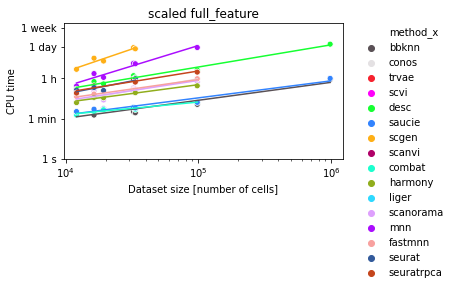

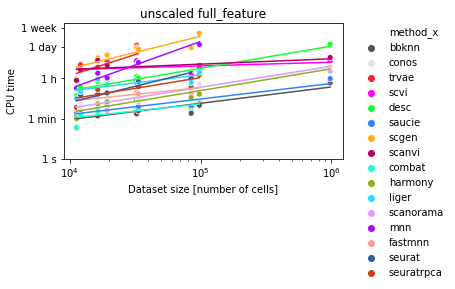

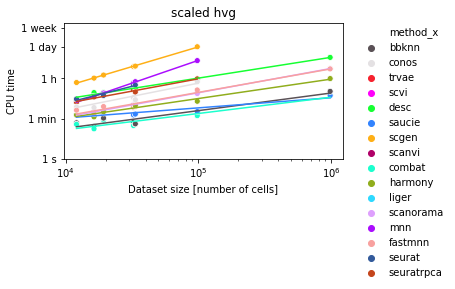

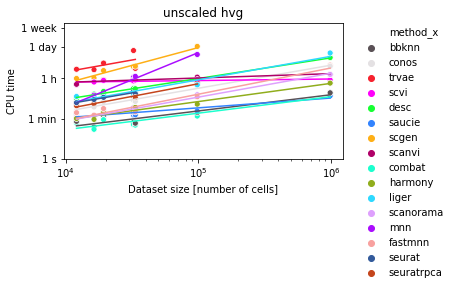

In [109]:
rcParams['figure.figsize'] = (5,2.5) 


for feat in ['full_feature', 'hvg']:
    for scala in ['scaled', 'unscaled']:
        tmp = another_test.loc[np.logical_and(another_test['features_x'] == feat,
                                           another_test['scale_x'] == scala
                                          ), :]
        ax = sb.scatterplot(x="size_x", y="s", hue='method_x',
                            hue_order=['bbknn', 'conos', 
                           'trvae', 'scvi', 'desc', 'saucie','scgen', 'scanvi', 
                                       'combat',
                           'harmony', 'liger', 'scanorama','mnn', 'fastmnn',
                           'seurat','seuratrpca'],
                            legend='brief',
                        #col='features', row='scale',
                        #order = meta['scenario'][np.argsort(meta['size'])].values,
                        data=tmp)
        ax.set(yscale="log") 
        ax.set(xscale="log")
        ax.set_title(scala + ' ' + feat)
        sb.lineplot(x='size_x', y='s_pred_lin', 
                    hue_order=['bbknn', 'conos', 
                           'trvae', 'scvi', 'desc', 'saucie','scgen', 'scanvi', 
                                       'combat',
                           'harmony', 'liger', 'scanorama','mnn', 'fastmnn',
                           'seurat','seuratrpca'],
                        legend = False,
                    hue='method_y', data=tmp, 
                       # palette='tab20c',
                    ax=ax)
        ax.set_xlabel('Dataset size [number of cells]')
        ax.set_ylabel('CPU time')
        ax.set_ylim([1, 1e6])
        plt.yticks([1, 60, 3600, 86400,604800], ['1 s', '1 min', '1 h', '1 day', '1 week'])
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
        plt.savefig('./../figures/time_' +scala + '_' + feat + '_revision.pdf', bbox_inches='tight')
        plt.show()

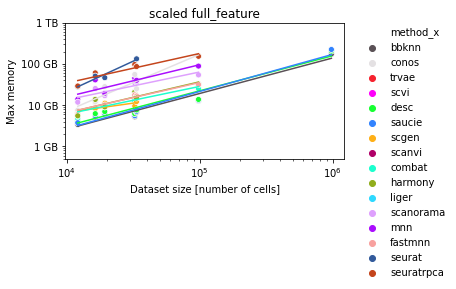

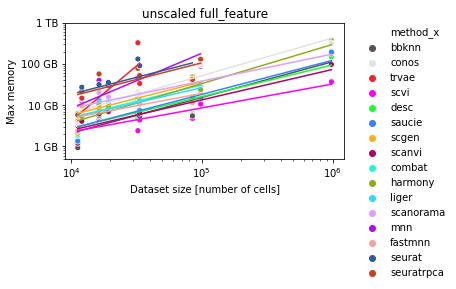

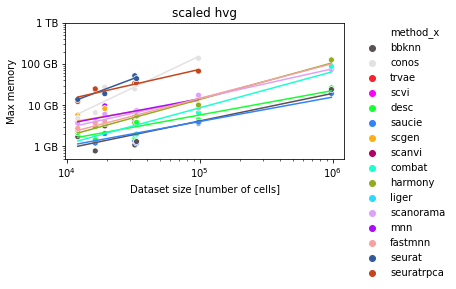

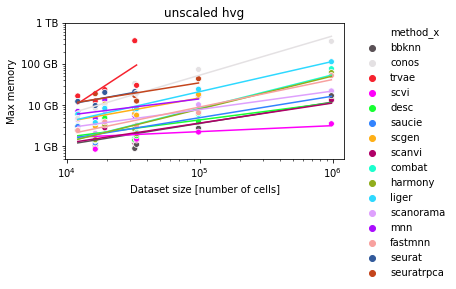

In [110]:
rcParams['figure.figsize'] = (5,2.5) 
for feat in ['full_feature', 'hvg']:
    for scala in ['scaled', 'unscaled']:
        tmp = another_test.loc[np.logical_and(another_test['features_x'] == feat,
                                           another_test['scale_x'] == scala
                                          ), :]
        ax = sb.scatterplot(x="size_x", y="max_pss", hue='method_x',
                            hue_order=['bbknn', 'conos', 
                           'trvae', 'scvi', 'desc', 'saucie','scgen', 'scanvi', 
                                       'combat',
                           'harmony', 'liger', 'scanorama','mnn', 'fastmnn',
                           'seurat','seuratrpca'],
                            legend='brief',
                        #col='features', row='scale',
                        #order = meta['scenario'][np.argsort(meta['size'])].values,
                        data=tmp)
        ax.set(yscale="log") 
        ax.set(xscale="log")
        ax.set_title(scala + ' ' + feat)
        sb.lineplot(x='size_x', y='memory_pred_lin', 
                    hue_order=['bbknn', 'conos', 
                           'trvae', 'scvi', 'desc', 'saucie','scgen', 'scanvi', 
                                       'combat',
                           'harmony', 'liger', 'scanorama','mnn', 'fastmnn',
                           'seurat','seuratrpca'],
                        legend = False,
                    hue='method_y', data=tmp, 
                        #palette='tab20c',
                    ax=ax)
        ax.set_xlabel('Dataset size [number of cells]')
        ax.set_ylabel('Max memory')
        ax.set_ylim([500, 1e6])
        plt.yticks([1e3, 1e4, 1e5, 1e6], ['1 GB', '10 GB', '100 GB', '1 TB'])
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., frameon=False)
        plt.savefig('./../figures/memory_' +scala + '_' + feat + '_revision.pdf', bbox_inches='tight')
        plt.show()

#### Compute scalability score

In order to derive a scalability score for each method, we compute the area under the fit curve and scale it with the area of a rectangle of the size 10^6-10^4 (size of largest dataset) and 10^8 s (in the time case, approximately equal to 24.1 days computation time on 48 cores). 

In [111]:
f_A = fit_params_time['slope_a']*np.log(10**4) + fit_params_time['intercept_b']

In [112]:
f_B = fit_params_time['slope_a']*np.log(10**6) + fit_params_time['intercept_b']

In [113]:
fit_params_time['AUC'] = 0.5*(np.log(10**6)-np.log(10**4))*(f_B+f_A)

In [114]:
fit_params_time['AUC_scaled'] = 1 - 0.5*(f_B+f_A)/np.log(10**8)

In [115]:
fit_params_time['metrics'] = [fit_params_time['scale'][idx[0]] + '/' + fit_params_time['features'][idx[0]] + '/' + fit_params_time['method'][idx[0]] for idx in enumerate(fit_params_time['method'])]

In [116]:
fit_for_file2 = fit_params_time[['metrics', 'AUC', 'AUC_scaled']]

In [117]:
fit_for_file2.to_csv('./../data/scalability_score_time_revision.csv')

In [118]:
fit_for_file2

,metrics,AUC,AUC_scaled
0,scaled/full_feature/bbknn,27.400017,0.677002
1,scaled/full_feature/combat,26.558695,0.686920
2,scaled/full_feature/conos,37.468739,0.558310
3,scaled/full_feature/desc,42.974205,0.493410
4,scaled/full_feature/fastmnn,37.122521,0.562391
5,scaled/full_feature/harmony,34.702409,0.590920
6,scaled/full_feature/mnn,53.021769,0.374967
7,scaled/full_feature/saucie,28.528051,0.663705
8,scaled/full_feature/scanorama,36.678446,0.567626
9,scaled/full_feature/scgen,61.983218,0.269327


We do the same for memory. Here, we use 10^7 MB as maximum (which corresponds to 10 TB). We derived the power `d` of this value such that the maximum of `0.5*(f_A + f_B)` is definitely smaller than `np.log(10**d)`. 

In [119]:
f_A = fit_params_memory['slope_a']*np.log(10**4) + fit_params_memory['intercept_b']

In [120]:
f_B = fit_params_memory['slope_a']*np.log(10**6) + fit_params_memory['intercept_b']

In [121]:
fit_params_memory['AUC'] = 0.5*(np.log(10**6)-np.log(10**4))*(f_B+f_A)

In [122]:
fit_params_memory['AUC_scaled'] = 1 - 0.5*(f_B+f_A)/np.log(10**7)

In [123]:
fit_params_memory['metrics'] = [fit_params_memory['scale'][idx[0]] + '/' + fit_params_memory['features'][idx[0]] + '/' + fit_params_memory['method'][idx[0]] for idx in enumerate(fit_params_memory['method'])]

In [124]:
fit_for_file = fit_params_memory[['metrics', 'AUC', 'AUC_scaled']]

In [125]:
fit_for_file['AUC_scaled'].max() - fit_for_file['AUC_scaled'].min()

0.4178526348340299

In [126]:
fit_for_file

,metrics,AUC,AUC_scaled
0,scaled/full_feature/bbknn,45.441940,0.387794
1,scaled/full_feature/combat,47.260105,0.363299
2,scaled/full_feature/conos,55.532692,0.251849
3,scaled/full_feature/desc,46.127032,0.378564
4,scaled/full_feature/fastmnn,48.271473,0.349674
5,scaled/full_feature/harmony,48.446133,0.347321
6,scaled/full_feature/mnn,52.849127,0.288003
7,scaled/full_feature/saucie,45.965513,0.380740
8,scaled/full_feature/scanorama,50.980587,0.313176
9,scaled/full_feature/scgen,45.341863,0.389142


In [127]:
fit_for_file.to_csv('./../data/scalability_score_memory_revision.csv')

## Examine the influence of the number of features on runtime and memory usage

In [4]:
import statsmodels

In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [5]:
statsmodels.__version__

'0.11.1'

Split by scaling and by method.

In [237]:
fit_params_time = pd.DataFrame({'method':[],  'scale' :[],
                           'slope_n_features' : [],
                           'slope_size': [], 'intercept_b': [], 
                                'pval_n_features' : [],
                           'pval_size': [], 'pval_intercept_b': []  
                          })

fit_params_memory = pd.DataFrame({'method':[],  'scale' : [],
                           'slope_n_features': [], 
                           'slope_size': [], 'intercept_b': [] ,
                                   'pval_n_features' : [],
                           'pval_size': [], 'pval_intercept_b': []  
                          })


In [238]:

for scala in ['scaled', 'unscaled']:

    tmp = runs_meta.loc[runs_meta['scale'] == scala
                                          , :]
    for method in np.unique(tmp['method']):
        tmp_meth = tmp.loc[tmp['method']== method,:]
        tmp_meth['size'] = np.log(tmp_meth['size'])
        tmp_meth['s'] = np.log(tmp_meth['s'])
        tmp_meth['max_pss'] = np.log(tmp_meth['max_pss'])
        tmp_meth['n_features'] = np.log(tmp_meth['n_features'])
        if len(tmp_meth)<2:
            continue
        else:
            #fit runtime relation
            mod = smf.ols(formula='s ~ size + n_features', data=tmp_meth)
            res = mod.fit()
        
            fit_params_time = fit_params_time.append({'method': method, 'scale' :scala,
                               'slope_n_features' : res.params[2],
                               'slope_size': res.params[1], 'intercept_b': res.params[0], 
                                                  'pval_n_features' : res.pvalues[2],
                           'pval_size': res.pvalues[1], 'pval_intercept_b': res.pvalues[0]
                                      }, ignore_index=True)
               
                                
                          
            #fit memory relation
            mod = smf.ols(formula='max_pss ~ size + n_features', data=tmp_meth)
            res = mod.fit()
        
            fit_params_memory = fit_params_memory.append({'method': method,  'scale' :scala,
                               'slope_n_features' : res.params[2],
                               'slope_size': res.params[1], 'intercept_b': res.params[0], 
                                                  'pval_n_features' : res.pvalues[2],
                           'pval_size': res.pvalues[1], 'pval_intercept_b': res.pvalues[0]
                           }, ignore_index=True)

<ipython-input-238-b921a26712b6>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_meth['size'] = np.log(tmp_meth['size'])
<ipython-input-238-b921a26712b6>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_meth['s'] = np.log(tmp_meth['s'])
<ipython-input-238-b921a26712b6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

In [239]:
fit_params_memory['log10p_n_features'] = -np.log10(fit_params_memory['pval_n_features'])
fit_params_memory['log10p_size'] = -np.log10(fit_params_memory['pval_size'])

In [240]:
fit_params_time['log10p_n_features'] = -np.log10(fit_params_time['pval_n_features'])
fit_params_time['log10p_size'] = -np.log10(fit_params_time['pval_size'])

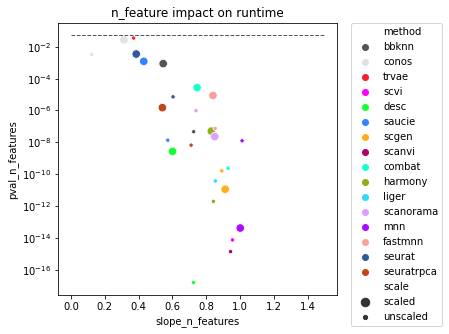

In [190]:
rcParams['figure.figsize'] = (5,5) 

ax = sb.scatterplot(x="slope_n_features", y="pval_n_features", hue='method', size='scale',
                            hue_order=['bbknn', 'conos', 
                           'trvae', 'scvi', 'desc', 'saucie','scgen', 'scanvi', 
                                       'combat',
                           'harmony', 'liger', 'scanorama','mnn', 'fastmnn',
                           'seurat','seuratrpca'],
                        #col='features', row='scale',
                        #order = meta['scenario'][np.argsort(meta['size'])].values,
                        data=fit_params_time)
ax.set(yscale="log") 
        #plt.yticks([1e3, 1e4, 1e5, 1e6], ['1 GB', '10 GB', '100 GB', '1 TB'])
        #ax.set(xscale="log")
ax.set_title('n_feature impact on runtime')
plt.plot([0, 1.5], [0.05, 0.05], linewidth=1, linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

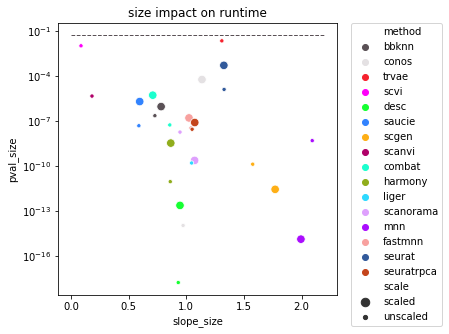

In [194]:
rcParams['figure.figsize'] = (5,5) 

ax = sb.scatterplot(x="slope_size", y="pval_size", hue='method', size='scale',
                            hue_order=['bbknn', 'conos', 
                           'trvae', 'scvi', 'desc', 'saucie','scgen', 'scanvi', 
                                       'combat',
                           'harmony', 'liger', 'scanorama','mnn', 'fastmnn',
                           'seurat','seuratrpca'],
                        #col='features', row='scale',
                        #order = meta['scenario'][np.argsort(meta['size'])].values,
                        data=fit_params_time)
ax.set(yscale="log") 
        #plt.yticks([1e3, 1e4, 1e5, 1e6], ['1 GB', '10 GB', '100 GB', '1 TB'])
        #ax.set(xscale="log")
ax.set_title('size impact on runtime')
plt.plot([0, 2.2], [0.05, 0.05], linewidth=1, linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

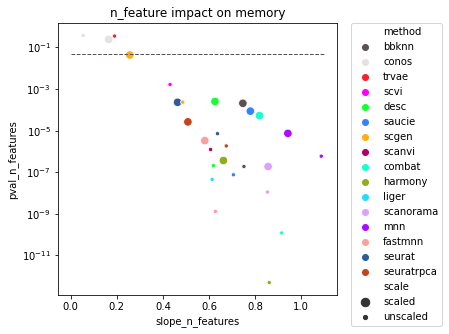

In [195]:
rcParams['figure.figsize'] = (5,5) 

ax = sb.scatterplot(x="slope_n_features", y="pval_n_features", hue='method', size='scale',
                            hue_order=['bbknn', 'conos', 
                           'trvae', 'scvi', 'desc', 'saucie','scgen', 'scanvi', 
                                       'combat',
                           'harmony', 'liger', 'scanorama','mnn', 'fastmnn',
                           'seurat','seuratrpca'],
                        #col='features', row='scale',
                        #order = meta['scenario'][np.argsort(meta['size'])].values,
                        data=fit_params_memory)
ax.set(yscale="log") 
        #plt.yticks([1e3, 1e4, 1e5, 1e6], ['1 GB', '10 GB', '100 GB', '1 TB'])
        #ax.set(xscale="log")
ax.set_title('n_feature impact on memory')
plt.plot([0, 1.1], [0.05, 0.05], linewidth=1, linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

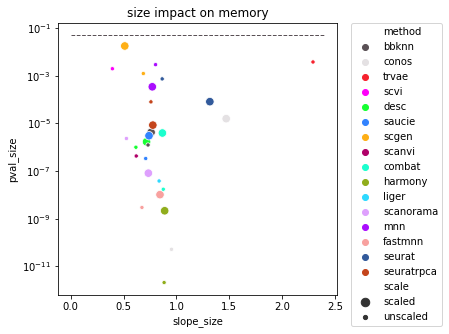

In [197]:
rcParams['figure.figsize'] = (5,5) 

ax = sb.scatterplot(x="slope_size", y="pval_size", hue='method', size='scale',
                            hue_order=['bbknn', 'conos', 
                           'trvae', 'scvi', 'desc', 'saucie','scgen', 'scanvi', 
                                       'combat',
                           'harmony', 'liger', 'scanorama','mnn', 'fastmnn',
                           'seurat','seuratrpca'],
                        #col='features', row='scale',
                        #order = meta['scenario'][np.argsort(meta['size'])].values,
                        data=fit_params_memory)
ax.set(yscale="log") 
        #plt.yticks([1e3, 1e4, 1e5, 1e6], ['1 GB', '10 GB', '100 GB', '1 TB'])
        #ax.set(xscale="log")
ax.set_title('size impact on memory')
plt.plot([0, 2.4], [0.05, 0.05], linewidth=1, linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

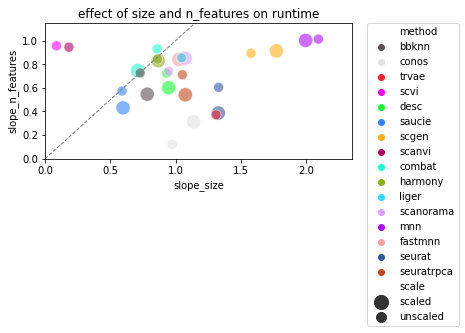

In [241]:
rcParams['figure.figsize'] = (5.5,2.5) 
fit_tmp = fit_params_time.loc[fit_params_time['pval_size']> 0]
ax = sb.scatterplot(x="slope_size", y="slope_n_features", hue='method', size='scale',sizes=(100, 200),
                    alpha=0.6,
                            hue_order=['bbknn', 'conos', 
                           'trvae', 'scvi', 'desc', 'saucie','scgen', 'scanvi', 
                                       'combat',
                           'harmony', 'liger', 'scanorama','mnn', 'fastmnn',
                           'seurat','seuratrpca'],
                        #col='features', row='scale',
                        #order = meta['scenario'][np.argsort(meta['size'])].values,
                        data=fit_tmp)
#ax.set(yscale="log") 
        #plt.yticks([1e3, 1e4, 1e5, 1e6], ['1 GB', '10 GB', '100 GB', '1 TB'])
        #ax.set(xscale="log")
ax.set_title('effect of size and n_features on runtime')
ax.set_ylim([0,1.15])
ax.set_xlim([0,2.35])
plt.plot([0, 1.2], [0, 1.2], linewidth=1, linestyle='--', color='grey')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('./../figures/runtime_model_all_revision.pdf', bbox_inches='tight')
plt.show()

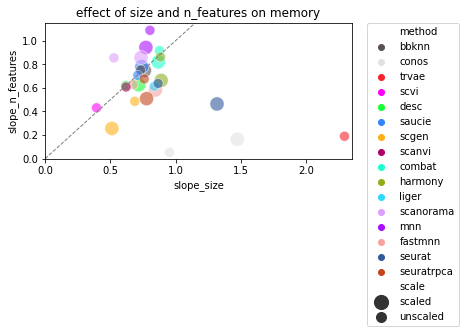

In [242]:
rcParams['figure.figsize'] = (5.5,2.5) 
fit_tmp = fit_params_memory.loc[fit_params_memory['pval_size']> 0]
ax = sb.scatterplot(x="slope_size", y="slope_n_features", hue='method',size='scale', 
                    sizes=(100, 200), alpha=0.6,
                            hue_order=['bbknn', 'conos', 
                           'trvae', 'scvi', 'desc', 'saucie','scgen', 'scanvi', 
                                       'combat',
                           'harmony', 'liger', 'scanorama','mnn', 'fastmnn',
                           'seurat','seuratrpca'],
                        #col='features', row='scale',
                        #order = meta['scenario'][np.argsort(meta['size'])].values,
                        data=fit_tmp)
#ax.set(yscale="log") 
        #plt.yticks([1e3, 1e4, 1e5, 1e6], ['1 GB', '10 GB', '100 GB', '1 TB'])
        #ax.set(xscale="log")
ax.set_title('effect of size and n_features on memory')
ax.set_ylim([0,1.15])
ax.set_xlim([0,2.35])
plt.plot([0, 1.2], [0, 1.2], linewidth=1, linestyle='--', color='grey')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('./../figures/memory_model_all_revision.pdf', bbox_inches='tight')
plt.show()

Plot without the scaled data.

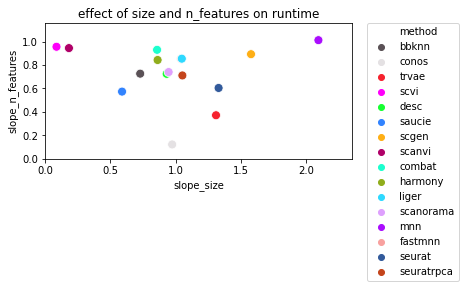

In [253]:
rcParams['figure.figsize'] = (5.5,2.5) 
fit_tmp = fit_params_time.loc[np.logical_and(fit_params_time['pval_size']> 0, fit_params_time['scale']=='unscaled')]
ax = sb.scatterplot(x="slope_size", y="slope_n_features", hue='method', s=80,
                   
                            hue_order=['bbknn', 'conos', 
                           'trvae', 'scvi', 'desc', 'saucie','scgen', 'scanvi', 
                                       'combat',
                           'harmony', 'liger', 'scanorama','mnn', 'fastmnn',
                           'seurat','seuratrpca'],
                        #col='features', row='scale',
                        #order = meta['scenario'][np.argsort(meta['size'])].values,
                        data=fit_tmp)
#ax.set(yscale="log") 
        #plt.yticks([1e3, 1e4, 1e5, 1e6], ['1 GB', '10 GB', '100 GB', '1 TB'])
        #ax.set(xscale="log")
ax.set_title('effect of size and n_features on runtime')
ax.set_ylim([0,1.16])
ax.set_xlim([0,2.35])
#plt.plot([0, 1.2], [0, 1.2], linewidth=1, linestyle='--', color='grey')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('./../figures/runtime_model_unscaled_revision.pdf', bbox_inches='tight')
plt.show()

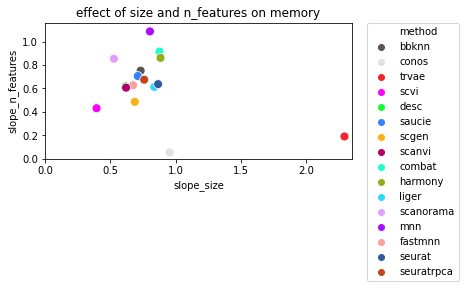

In [254]:
rcParams['figure.figsize'] = (5.5,2.5) 
fit_tmp = fit_params_memory.loc[np.logical_and(fit_params_memory['pval_size']> 0, fit_params_memory['scale']=='unscaled')]
ax = sb.scatterplot(x="slope_size", y="slope_n_features", hue='method', s=80,
                   
                            hue_order=['bbknn', 'conos', 
                           'trvae', 'scvi', 'desc', 'saucie','scgen', 'scanvi', 
                                       'combat',
                           'harmony', 'liger', 'scanorama','mnn', 'fastmnn',
                           'seurat','seuratrpca'],
                        #col='features', row='scale',
                        #order = meta['scenario'][np.argsort(meta['size'])].values,
                        data=fit_tmp)
#ax.set(yscale="log") 
        #plt.yticks([1e3, 1e4, 1e5, 1e6], ['1 GB', '10 GB', '100 GB', '1 TB'])
        #ax.set(xscale="log")
ax.set_title('effect of size and n_features on memory')
ax.set_ylim([0,1.16])
ax.set_xlim([0,2.35])
#plt.plot([0, 1.2], [0, 1.2], linewidth=1, linestyle='--', color='grey')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('./../figures/memory_model_unscaled_revision.pdf', bbox_inches='tight')
plt.show()

### Fit only ATAC data.

In [221]:
fit_params_time = pd.DataFrame({'method':[], 
                           'slope_n_features' : [],
                           'slope_size': [], 'intercept_b': [], 
                                'pval_n_features' : [],
                           'pval_size': [], 'pval_intercept_b': []  
                          })

fit_params_memory = pd.DataFrame({'method':[], 
                           'slope_n_features': [], 
                           'slope_size': [], 'intercept_b': [] ,
                                   'pval_n_features' : [],
                           'pval_size': [], 'pval_intercept_b': []  
                          })


In [222]:
feat ='full_feature'
scala = 'unscaled'

runs_ATAC = runs_meta.loc[np.logical_and(runs_meta['scenario_type']=='ATAC',np.logical_and(runs_ATAC['features'] == feat,
                                           runs_ATAC['scale'] == scala
                                          )), :]


for method in np.unique(runs_ATAC['method']):
    tmp_meth = runs_ATAC.loc[runs_ATAC['method']== method,:]
    tmp_meth['size'] = np.log(tmp_meth['size'])
    tmp_meth['s'] = np.log(tmp_meth['s'])
    tmp_meth['max_pss'] = np.log(tmp_meth['max_pss'])
    tmp_meth['n_features'] = np.log(tmp_meth['n_features'])
    if len(tmp_meth)<2:
        continue
    else:
        #fit runtime relation
        mod = smf.ols(formula='s ~ size + n_features', data=tmp_meth)
        res = mod.fit()
        
        fit_params_time = fit_params_time.append({'method': method, 
                               'slope_n_features' : res.params[2],
                               'slope_size': res.params[1], 'intercept_b': res.params[0], 
                                                  'pval_n_features' : res.pvalues[2],
                           'pval_size': res.pvalues[1], 'pval_intercept_b': res.pvalues[0]
                                      }, ignore_index=True)
               
                                
                          
        #fit memory relation
        mod = smf.ols(formula='max_pss ~ size + n_features', data=tmp_meth)
        res = mod.fit()
        
        fit_params_memory = fit_params_memory.append({'method': method, 
                               'slope_n_features' : res.params[2],
                               'slope_size': res.params[1], 'intercept_b': res.params[0], 
                                                  'pval_n_features' : res.pvalues[2],
                           'pval_size': res.pvalues[1], 'pval_intercept_b': res.pvalues[0]
                           }, ignore_index=True)


<ipython-input-222-dc2f5b4b191a>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_meth['size'] = np.log(tmp_meth['size'])
<ipython-input-222-dc2f5b4b191a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_meth['s'] = np.log(tmp_meth['s'])
<ipython-input-222-dc2f5b4b191a>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [223]:
fit_params_time

,method,slope_n_features,slope_size,intercept_b,pval_n_features,pval_size,pval_intercept_b
0,bbknn,0.893899,0.911683,-12.841201,0.000735,0.002747,0.001793
1,combat,1.002076,1.153142,-16.064671,0.001780,0.004617,0.003125
2,conos,0.140022,0.993284,-5.409613,0.101932,0.001915,0.018902
3,desc,0.759820,0.971358,-8.849522,0.000035,0.000069,0.000164
4,fastmnn,0.743949,0.733614,-7.871421,0.006601,0.012980,0.016210
5,harmony,0.912089,0.943260,-12.041843,0.000424,0.001534,0.001334
6,liger,0.951464,1.047858,-11.653832,0.000873,0.002601,0.003386
7,mnn,0.795771,12.973664,-120.343425,NaN,NaN,NaN
8,saucie,0.610327,0.731753,-7.702685,0.006998,0.015577,0.023086
9,scanorama,0.889177,1.605625,-18.013548,0.006208,0.006666,0.007963


In [224]:
fit_params_memory

,method,slope_n_features,slope_size,intercept_b,pval_n_features,pval_size,pval_intercept_b
0,bbknn,0.801930,1.016473,-9.335997,0.000394,0.000781,0.001795
1,combat,0.914849,1.011431,-9.340323,0.000112,0.000335,0.000763
2,conos,0.188964,1.099744,-3.648773,0.033448,0.000856,0.034003
3,desc,0.648945,0.779500,-5.322606,0.000075,0.000175,0.000979
4,fastmnn,0.701368,0.783288,-5.268390,0.006795,0.011798,0.023498
5,harmony,0.832030,1.076006,-9.262755,0.000056,0.000105,0.000296
6,liger,0.847643,0.968121,-8.355437,0.000005,0.000014,0.000039
7,mnn,1.419427,18.817023,-179.545205,NaN,NaN,NaN
8,saucie,0.780593,0.931390,-8.062424,0.000874,0.002060,0.005546
9,scanorama,0.922143,1.036883,-8.968618,0.000391,0.000675,0.001046


In [225]:
fit_params_memory['log10p_n_features'] = -np.log10(fit_params_memory['pval_n_features'])
fit_params_memory['log10p_size'] = -np.log10(fit_params_memory['pval_size'])

In [226]:
fit_params_time['log10p_n_features'] = -np.log10(fit_params_time['pval_n_features'])
fit_params_time['log10p_size'] = -np.log10(fit_params_time['pval_size'])

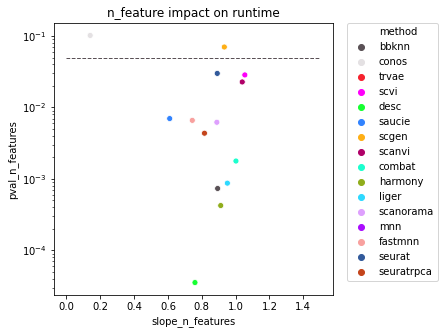

In [227]:
rcParams['figure.figsize'] = (5,5) 

ax = sb.scatterplot(x="slope_n_features", y="pval_n_features", hue='method', 
                            hue_order=['bbknn', 'conos', 
                           'trvae', 'scvi', 'desc', 'saucie','scgen', 'scanvi', 
                                       'combat',
                           'harmony', 'liger', 'scanorama','mnn', 'fastmnn',
                           'seurat','seuratrpca'],
                        #col='features', row='scale',
                        #order = meta['scenario'][np.argsort(meta['size'])].values,
                        data=fit_params_time)
ax.set(yscale="log") 
        #plt.yticks([1e3, 1e4, 1e5, 1e6], ['1 GB', '10 GB', '100 GB', '1 TB'])
        #ax.set(xscale="log")
ax.set_title('n_feature impact on runtime')
plt.plot([0, 1.5], [0.05, 0.05], linewidth=1, linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

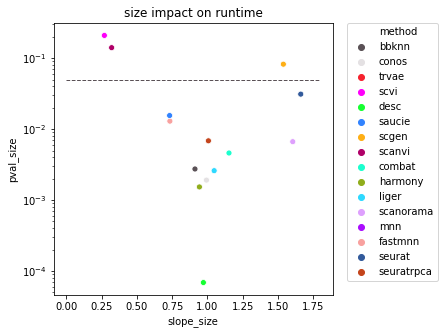

In [228]:
rcParams['figure.figsize'] = (5,5) 

ax = sb.scatterplot(x="slope_size", y="pval_size", hue='method',
                            hue_order=['bbknn', 'conos', 
                           'trvae', 'scvi', 'desc', 'saucie','scgen', 'scanvi', 
                                       'combat',
                           'harmony', 'liger', 'scanorama','mnn', 'fastmnn',
                           'seurat','seuratrpca'],
                        #col='features', row='scale',
                        #order = meta['scenario'][np.argsort(meta['size'])].values,
                        data=fit_params_time)
ax.set(yscale="log") 
        #plt.yticks([1e3, 1e4, 1e5, 1e6], ['1 GB', '10 GB', '100 GB', '1 TB'])
        #ax.set(xscale="log")
ax.set_title('size impact on runtime')
plt.plot([0, 1.8], [0.05, 0.05], linewidth=1, linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

Comment: Create another plot without MNN and trVAE.

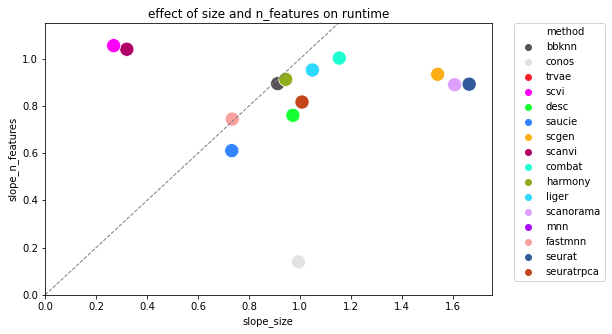

In [235]:
rcParams['figure.figsize'] = (8,5) 
fit_tmp = fit_params_time.loc[fit_params_time['pval_size']> 0]
ax = sb.scatterplot(x="slope_size", y="slope_n_features", hue='method', s=200,
                            hue_order=['bbknn', 'conos', 
                           'trvae', 'scvi', 'desc', 'saucie','scgen', 'scanvi', 
                                       'combat',
                           'harmony', 'liger', 'scanorama','mnn', 'fastmnn',
                           'seurat','seuratrpca'],
                        #col='features', row='scale',
                        #order = meta['scenario'][np.argsort(meta['size'])].values,
                        data=fit_tmp)
#ax.set(yscale="log") 
        #plt.yticks([1e3, 1e4, 1e5, 1e6], ['1 GB', '10 GB', '100 GB', '1 TB'])
        #ax.set(xscale="log")
ax.set_title('effect of size and n_features on runtime')
ax.set_ylim([0,1.15])
ax.set_xlim([0,1.75])
plt.plot([0, 1.2], [0, 1.2], linewidth=1, linestyle='--', color='grey')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('./../figures/runtime_model_ATAC_revision.pdf', bbox_inches='tight')
plt.show()

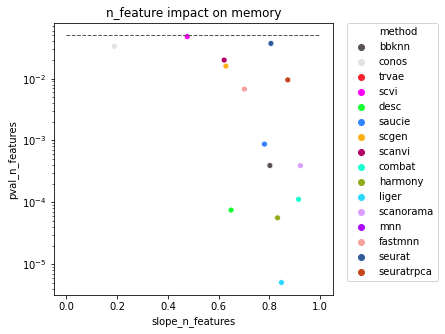

In [230]:
rcParams['figure.figsize'] = (5,5) 

ax = sb.scatterplot(x="slope_n_features", y="pval_n_features", hue='method', 
                            hue_order=['bbknn', 'conos', 
                           'trvae', 'scvi', 'desc', 'saucie','scgen', 'scanvi', 
                                       'combat',
                           'harmony', 'liger', 'scanorama','mnn', 'fastmnn',
                           'seurat','seuratrpca'],
                        #col='features', row='scale',
                        #order = meta['scenario'][np.argsort(meta['size'])].values,
                        data=fit_params_memory)

ax.set(yscale="log") 
        #plt.yticks([1e3, 1e4, 1e5, 1e6], ['1 GB', '10 GB', '100 GB', '1 TB'])
        #ax.set(xscale="log")
ax.set_title('n_feature impact on memory')

plt.plot([0, 1], [0.05, 0.05], linewidth=1, linestyle='--')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

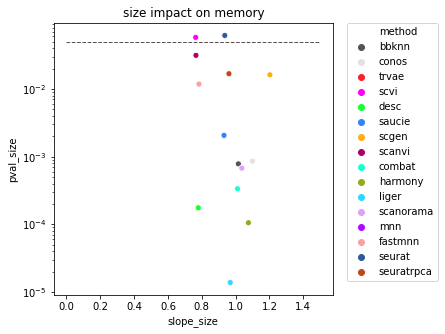

In [231]:
rcParams['figure.figsize'] = (5,5) 

ax = sb.scatterplot(x="slope_size", y="pval_size", hue='method', 
                            hue_order=['bbknn', 'conos', 
                           'trvae', 'scvi', 'desc', 'saucie','scgen', 'scanvi', 
                                       'combat',
                           'harmony', 'liger', 'scanorama','mnn', 'fastmnn',
                           'seurat','seuratrpca'],
                        #col='features', row='scale',
                        #order = meta['scenario'][np.argsort(meta['size'])].values,
                        data=fit_params_memory)

ax.set(yscale="log") 
        #plt.yticks([1e3, 1e4, 1e5, 1e6], ['1 GB', '10 GB', '100 GB', '1 TB'])
        #ax.set(xscale="log")
ax.set_title('size impact on memory')

plt.plot([0, 1.5], [0.05, 0.05], linewidth=1, linestyle='--')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

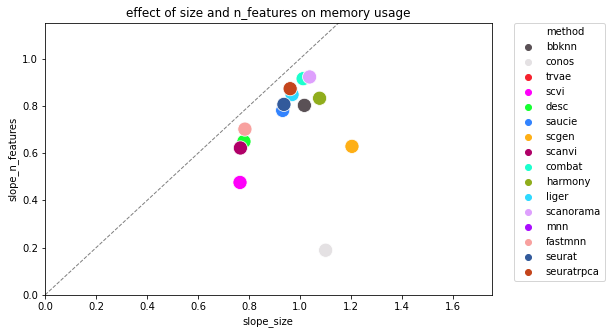

In [234]:
rcParams['figure.figsize'] = (8,5) 
fit_tmp = fit_params_memory.loc[fit_params_memory['pval_size']> 0]
ax = sb.scatterplot(x="slope_size", y="slope_n_features", hue='method', s=200,
                            hue_order=['bbknn', 'conos', 
                           'trvae', 'scvi', 'desc', 'saucie','scgen', 'scanvi', 
                                       'combat',
                           'harmony', 'liger', 'scanorama','mnn', 'fastmnn',
                           'seurat','seuratrpca'],
                        #col='features', row='scale',
                        #order = meta['scenario'][np.argsort(meta['size'])].values,
                        data=fit_tmp)
#ax.set(yscale="log") 
        #plt.yticks([1e3, 1e4, 1e5, 1e6], ['1 GB', '10 GB', '100 GB', '1 TB'])
        #ax.set(xscale="log")
ax.set_title('effect of size and n_features on memory usage')
ax.set_ylim([0,1.15])
ax.set_xlim([0,1.75])
plt.plot([0, 1.2], [0, 1.2], linewidth=1, linestyle='--', color='grey')
#plt.plot([0, 1.8], [0.05, 0.05], linewidth=1, linestyle='--')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('./../figures/memory_model_ATAC_revision.pdf', bbox_inches='tight')
plt.show()